In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import anndata
import os

scvi.settings.seed = 1

In [2]:
counts = pd.read_csv('data_tm/star_counts.tab', index_col=0)
rd = pd.read_csv('data_tm/rd.tab', sep='\t', index_col=0)
# meta = pd.read_csv('data_ml/SraRunTable.txt', index_col=0)
# star_meta = pd.read_csv('data_tm/star_meta.tab', sep='\t', index_col=0)

# discard = ['EGFP'] + [x for x in counts.index if x[:5]=='ERCC-']
# good_genes = [x for x in counts.index if x not in discard]



In [3]:
accession_map = pd.read_csv('data_tm/GSE109774_list_of_SRR_accessions_and_raw_filenames.txt', sep='\t', index_col=1,
                           names=['GSM', 'fq1', 'fq2'])
annotations = pd.read_csv('data_tm/annotations_facs.csv', index_col=2)

/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
accession_map = accession_map.loc[rd.index]
annotations_id = ['.'.join(accession_map.loc[cell].fq1[:-15].split('-')) for cell in rd.index]
accession_map['annotations_id'] = annotations_id
annotations_cells = annotations.index & pd.Index(annotations_id)

/home/eecs/cfbuenabadn/anaconda3/envs/scvi-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  after removing the cwd from sys.path.


In [5]:
cell_type = []
subtissue = []
sex = []
for idx, row in accession_map.iterrows():
    try:
        cell_type.append(annotations.loc[row.annotations_id, 'cell_ontology_class'])
        subtissue.append(annotations.loc[row.annotations_id, 'subtissue'])
        sex.append(annotations.loc[row.annotations_id, 'mouse.sex'])
    except:
        cell_type.append('unknown')
        subtissue.append('unknown')
        sex.append('unknown')
        


In [ ]:
counts = counts[rd.index].T

adata = anndata.AnnData(counts)

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata


scvi.data.setup_anndata(adata, layer="counts")

sc.set_figure_params(figsize=(4, 4))


sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


scvi.data.setup_anndata(adata, layer="counts")

model = scvi.model.SCVI(adata)


model.train()


model.save("my_model_tm/")


latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)

sc.tl.pca(adata)


adata.obs['cell_type'] = cell_type
adata.obs['subtissue'] = subtissue
adata.obs['sex'] = sex

In [ ]:
scvi_rd = pd.DataFrame(adata.obsm['X_scVI'])
scvi_rd.index = adata.obs.index
scvi_rd.columns = ['scvi_' + str(x) for x in range(1, 11)]

scvi_rd.to_csv('tm_scvi_rd.tab', sep='\t', index=True, header=True)

In [ ]:
sc.pl.umap(
    adata,
    color="cell_type",
    frameon=False,
)

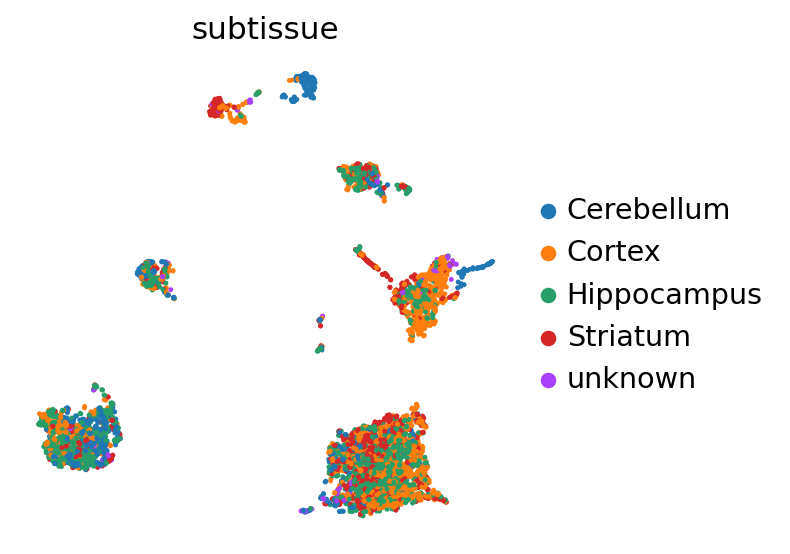

In [90]:
sc.pl.umap(
    adata,
    color="subtissue",
    frameon=False,
)

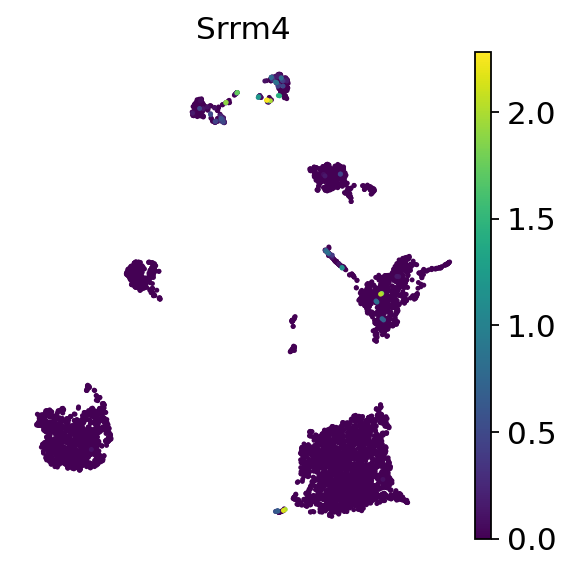

In [101]:
sc.pl.umap(
    adata,
    color="Srrm4",
    frameon=False,
)

In [103]:
sc.tl.tsne(adata)


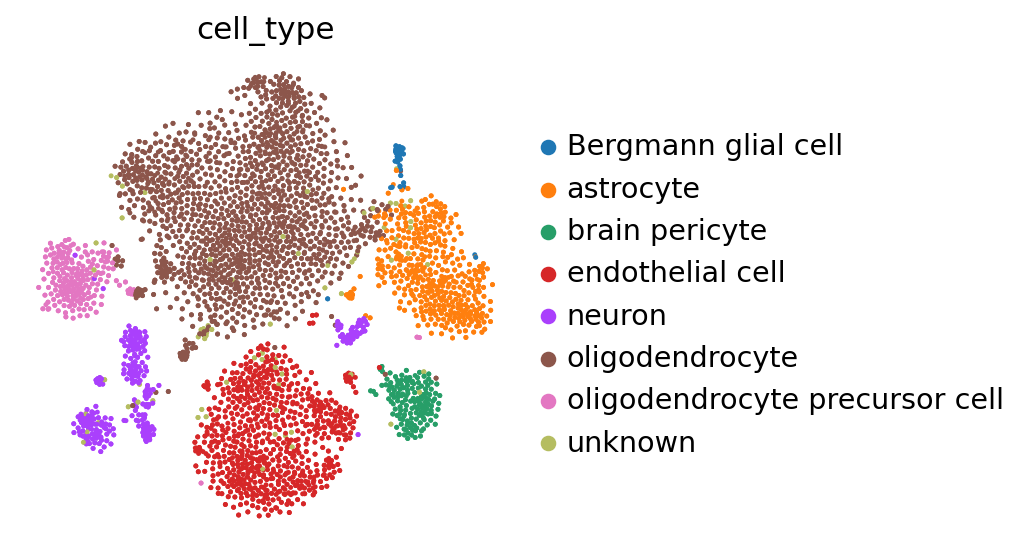

In [104]:
sc.pl.tsne(
    adata,
    color="cell_type",
    frameon=False,
)

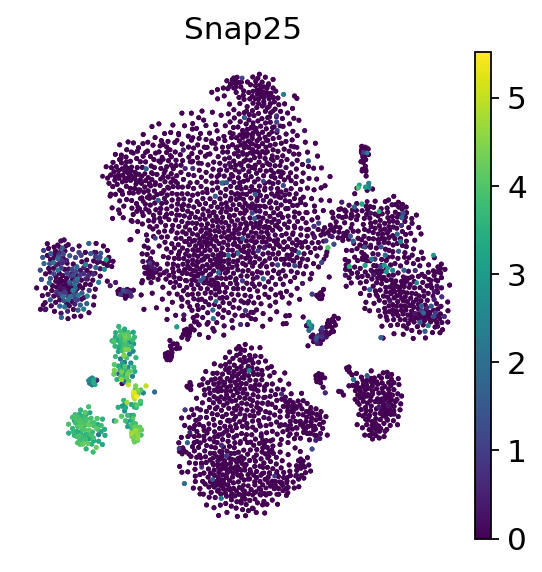

In [106]:
sc.pl.tsne(
    adata,
    color="Snap25",
    frameon=False,
)

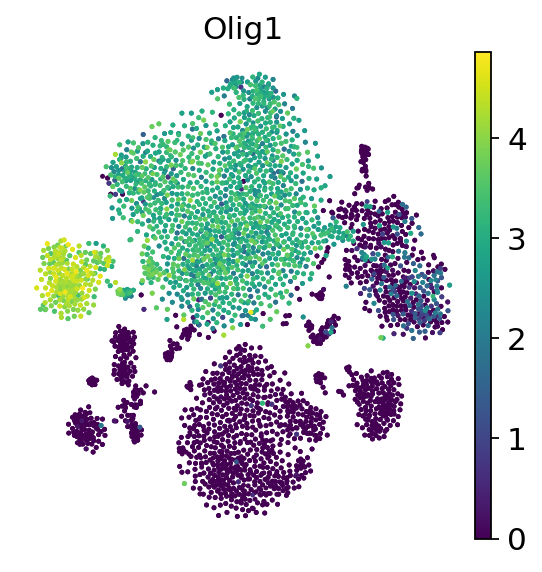

In [107]:
sc.pl.tsne(
    adata,
    color="Olig1",
    frameon=False,
)